# Development version 8.5.21:1900

In [4]:
import numpy as np

# This method finds the location of all peaks in the full spectrum
# Output (Indices) contains the start index and end index of each peak
# It is assumed that the structure of the data is coherent.

def findPeakIndices(data):

# each peak in 'data' starts and ends with a zero
# so that there are two zeros between each peak
# =============================================

    n = int(round(sum(data.iloc[:,1] == 0)/2)+1) # n is just the upper limit for the number of peaks
    indices = np.zeros([n,2], dtype="uint32")    # true n may be lower

    ii = 0                                       # index for indices
    indices[ii,0] = 0
    i = 1
    while i < len(data):
        if data.iloc[i,1] == 0:     
            if (i+1) == len(data):
                indices[ii,1] = i
            elif data.iloc[i+1,1] == 0:
                indices[ii,1] = i
                ii = ii+1
                i = i+1
                indices[ii,0] = i
        i = i+1
        
# n may be too large, because there are sometimes single zeros within peaks
# therefore, extra indices are cut out
    indices = indices[0:ii+1,:]
    return indices

# KO 6.4. zeros in the beginning and end are now included in indexed peaks
# Another way to save the indices could also be used: 
# add 1 to every indices[ii,0]
# minus 1 from every indices[ii,1]

In [5]:
from scipy.optimize import leastsq
import numpy as np
import math

def getMean(peak):
    mu = np.average(peak.iloc[:,0], weights=peak.iloc[:,1])  # painotettu keskiarvo

    sigma = mu/(280000*2*np.sqrt(2*np.log(2)))
    fitfunc =  lambda p, x: p[0]*np.exp(-0.5*((x-p[1])/sigma)**2)
    errfunc  = lambda p, x, y: (y - fitfunc(p, x))
    init  = [1.0, mu]

    out = leastsq(errfunc, init, args=(peak.iloc[:,0], peak.iloc[:,1]))                 
    c = out[0]
    return sigma, c[1]

# Modified 3-5.4. by KO

In [7]:
import numpy as np

def getAllMeans(data):
    indices = findPeakIndices(data)
    peakAreas = getAllAreas(data,indices)
    peakSkews = getAllSkews(data,indices)

    n = len(indices)  
    means = np.zeros(n)
    sigmas = np.zeros(n)
    lefts = np.zeros(n)
    rights = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        sigmas[i], means[i] = getMean(peak)
        lefts[i] = indices[i,0]
        rights[i] = indices[i,1]

    return sigmas, means, peakAreas, peakSkews, lefts, rights


In [6]:
import numpy as np

# Get all peak means for the data
def XgetAllMeans(peaks):    # NOT IN USE
    indices = findPeakIndices(peaks)
    n = len(indices[:,0])
    means = []
    aa = []
    sigmas = []
    peaki = []
    for i in range(n):
        peak = peaks[indices[i,0]:indices[i,1]+1,:]
        mu, a, sigma = getMeans(peak)
        for ii in range(len(a)):
            means += [mu[ii]]
            aa += [a[ii]]
            sigmas += [sigma[ii]]
            peaki += [i]
    return means, aa, sigmas, peaki

# This JKo method is not implemented!

## getArea

Actual area of the peak is calculated from the peak histogram.

In [161]:
import numpy as np

def getArea(peak):
    zum = 0         # m/z channels have different widths, but we count intensities
    for i in range(1,len(peak)-1):
        zum = zum + peak.iloc[i,1]

        #
# After all it was realized that the next line does not give proper counts
#
#    zum = zum * (peak.iloc[len(peak)-1,0]-peak.iloc[1,0])/(len(peak)-2)
    return zum

# KO 4.4. & 8.5

In [9]:
import pandas as pd
import numpy as np

def getAllAreas(data, indices):

    n = len(indices)
    areas = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        areas[i] = getArea(peak)
#    print("all areas ok")
    return areas

# KO 4.4.

In [10]:
import numpy as np
# Pandas has its own skew method.
import pandas as pd

def getSkew(peak):
    dta=peak.iloc[:,1]
    skw = dta.skew(axis = 0)
    return skw

# KO 5.4.

In [11]:
import pandas as pd
import numpy as np

def getAllSkews(data, indices):

    n = len(indices)
    skews = np.zeros(n)
    for i in range(n):
        peak = data.iloc[indices[i,0]:indices[i,1]+1,:]
        skews[i] = getSkew(peak)

    return skews

# KO 9.3.

In [156]:
import pandas as pd
import numpy as np

def getPeak(i, peaklist, interest):
    ix = 0
    # ion index i is here changed to array index ix 
    for j in range(len(peaklist)):
        if peaklist.iloc[j,9] == i:
            ix = j
    if interest:
        print("Peak of interest: ",peaklist.iloc[ix,0])

    left = int(peaklist.iloc[ix,7])
    right = int(peaklist.iloc[ix,8])
    peak = data[left:right+1]
#    print("L R: ",left,right)    
#    print(peak)  # To show tha actual peak data in numbers
    return ix, peak

# KO 5.4.

## addGaussians

Gaussian model from lmfit library is fitted on each peak.

Center, sigma, and fwhm are saved in the peaklist dataframe.

In [13]:
import pandas as pd
import numpy as np
from lmfit.models import GaussianModel, LorentzianModel, VoigtModel
#from lmfit import fit_report

def addGaussians(peaklist):
    
    for i in range(len(peaklist)):  
        index = peaklist.iloc[i,9]                                 #  for the INDEX column
        ix, peak = getPeak(index,peaklist, False)
        df = pd.DataFrame(peak, columns = ['x','y'])
        cc = len(peak.iloc[:,0])
        df['index'] = np.arange(cc).reshape(cc,1)
        df['x'] = peak.iloc[:,0]
        df['y'] = peak.iloc[:,1]
        df.set_index('index', inplace = True)

        model = GaussianModel()
        params = model.guess(df['y'], x=df['x'])
        result = model.fit(df['y'], params, x=df['x'])
        for parname, param in result.params.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
            if parname == 'center':
                centerGv = param.value
            if parname == 'sigma':
                sigmaGv = param.value
            if parname == 'fwhm':
                fwhmGv = param.value
                
        peaklist.iloc[i,10] = centerGv
        peaklist.iloc[i,11] = sigmaGv
        peaklist.iloc[i,12] = fwhmGv

        
        
        model = LorentzianModel()
        params = model.guess(df['y'], x=df['x'])
        result = model.fit(df['y'], params, x=df['x'])
        for parname, param in result.params.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
            if parname == 'center':
                centerLv = param.value
            if parname == 'sigma':
                sigmaLv = param.value
            if parname == 'fwhm':
                fwhmLv = param.value
                
        peaklist.iloc[i,13] = centerLv
        peaklist.iloc[i,14] = sigmaLv
        peaklist.iloc[i,15] = fwhmLv

        
        
#        model = VoigtModel()
#        pars = model.guess(df['y'], x=df['x'])
#        pars['gamma'].set(value=0.7, vary=True, expr='')
#        result  = model.fit(df['y'], pars, x=df['x'])
        
#        for parname, param in result.pars.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
#            if parname == 'center':
#                centerVv = param.value
#            if parname == 'sigma':
#                sigmaVv = param.value
#            if parname == 'fwhm':
#                fwhmVv = param.value
                
#        peaklist.iloc[i,16] = centerVv
#        peaklist.iloc[i,17] = sigmaVv
#        peaklist.iloc[i,18] = fwhmVv
        
# KO 6.5. rewritten

## addVoigt

Voigt model from lmfit library is fitted on each peak.

Center, sigma, and fwhm are saved in the peaklist dataframe

Some problem with this when trying to do this again. Skip this.

In [14]:
import pandas as pd
import numpy as np
from lmfit.models import VoigtModel
from lmfit import fit_report

def addVoigt(peaklist):
    
    for i in range(len(peaklist)):  
        index = peaklist.iloc[i,9]                                 #  for the INDEX column

        ix, peak = getPeak(index,peaklist, False)
        dfd = pd.DataFrame(peak, columns = ['x','y'])
        cc = len(peak.iloc[:,0])
        dfd['index'] = np.arange(cc).reshape(cc,1)
        dfd['x'] = peak.iloc[:,0]
        dfd['y'] = peak.iloc[:,1]
        dfd.set_index('index', inplace = True)

        print(dfd)
        print(dfd.dtypes)

        model = VoigtModel()
        params = model.guess(dfd['y'], x=dfd['x'])
        print(params)
        result = model.fit(dfd['y'], params, x=dfd['x'])
        print(result)


#print(out.fit_report(min_correl=0.25))
        
#Parameters([('amplitude', <Parameter 'amplitude', value=509.59811179953465, bounds=[-inf:inf]>), 
#            ('center', <Parameter 'center', value=61.98837236406859, bounds=[-inf:inf]>), 
#            ('sigma', <Parameter 'sigma', value=1.8807115455565794e-05, bounds=[0.0:inf]>), 

        
        for parname, param in result.params.items():
#            print("%s = %f +/- %f " % (parname, param.value, param.stderr))
            if parname == 'center':
                centerVv = param.value
            if parname == 'sigma':
                sigmaVv = param.value
            if parname == 'fwhm':
                fwhmVv = param.value
                
        peaklist.iloc[i,16] = centerVv
        peaklist.iloc[i,17] = sigmaVv
        peaklist.iloc[i,18] = fwhmVv
        
# KO 6.5.

In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plotPeak(i, peaklist):

    ix, peak = getPeak(i, peaklist, True)
    
    plt.plot(peak.iloc[:,0],peak.iloc[:,1])
    plt.vlines(peaklist.iloc[ix,2],0,max(peak.iloc[:,1]))
    plt.vlines(peaklist.iloc[ix,1],0,max(peak.iloc[:,1]), color = "green")

    plt.legend(["Data","Mean from data","True mean"])
    plt.title(peaklist.iloc[ix,0])
    plt.show()
    
# KO 5.4.

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#from lmfit.models import LorentzianModel
from lmfit.models import GaussianModel

def plotGaussian(i, peaklist):
    
    ix, peak = getPeak(i, peaklist, True)  
    
# read the data into a pandas DataFrame, and use the ‘x’ and ‘y’ columns:
# Sata is already in such a dataframe
# dframe = pd.read_csv('peak.csv')

    df = pd.DataFrame(peak, columns = ['x','y'])
    cc = len(peak.iloc[:,0])
    df['index'] = np.arange(cc).reshape(cc,1)
    df['x'] = peak.iloc[:,0]
    df['y'] = peak.iloc[:,1]
#    df['y'] = np.log(peak.iloc[:,1] )  # needs improvement.. log was to handle skewed peaks
    df.set_index('index', inplace = True)
    print(df)

#    model = LorentzianModel()   # was not as good as Gaussian
    model = GaussianModel()
    params = model.guess(df['y'], x=df['x'])
    result = model.fit(df['y'], params, x=df['x'])

# and gives the plot and fitting results below:

    result.plot_fit()
    plt.show()

    print(result.fit_report())

# KO 5.4.

In [23]:
import pandas as pd
import numpy as np

# maxDistance below = 'th' in JKolis's code

def identifyPeaks(data, peaklist, maxDistance):    
    peaklist['observed'] = np.zeros(len(peaklist['mz'])) #2
    peaklist['peak'] = np.zeros(len(peaklist['mz']), dtype="uint32")     #3
    peaklist['area'] = np.zeros(len(peaklist['mz']))     #4
    peaklist['skew'] = np.zeros(len(peaklist['mz']))     #5
    peaklist['sigma'] = np.zeros(len(peaklist['mz']))    #6
    peaklist['lefti']  = np.zeros(len(peaklist['mz']), dtype="uint32")   #7
    peaklist['righti'] = np.zeros(len(peaklist['mz']), dtype="uint32")   #8
#    peaklist['centerG'] = np.zeros(len(peaklist['mz']))   #9
#    peaklist['sigmaG']  = np.zeros(len(peaklist['mz']))   #10
#    peaklist['fwhmG'] = np.zeros(len(peaklist['mz']))   #11    

    sigmas, peakMeans, peakAreas, peakSkews, lefts, rights = getAllMeans(data)
    trueValue = peaklist['mz'].to_numpy()     # get only the mz values from the peaklist

    for i in range(len(trueValue)):
        if min(abs(peakMeans - trueValue[i])) < maxDistance:      # there is at least one
            ind = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,2] = peakMeans[ind]
            peaklist.iloc[i,3] = np.argmin(abs(peakMeans - trueValue[i]))
            peaklist.iloc[i,4] = peakAreas[ind]
            peaklist.iloc[i,5] = peakSkews[ind]
            peaklist.iloc[i,6] = sigmas[ind]
            peaklist.iloc[i,7] = int(lefts[ind])
            peaklist.iloc[i,8] = int(rights[ind])

    unidentified = np.linspace(0, len(trueValue)-1, len(trueValue))
    unidentified = unidentified[peaklist['observed'].to_numpy() == 0]
  
    identified = np.linspace(0, len(trueValue)-1, len(trueValue))
    identified = identified[peaklist['observed'].to_numpy() != 0]    

#    unidentified: 'observed' == 0, because it never got any actual value

    return peaklist.drop(unidentified)

# Modified by KO 31.3.-6.4.

## readSpectrum

Change the name of the 'dataDir' to match your own folder of spectra.

Parameter n refers to the nth file in your folder.

In [17]:
# Method to read in one spectrum
# You need to give the folder name in this method

# A large number of averaged, denoised spectra was exported from Orbitool into folders
# Exported with Antonio's "all denoised" button

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import glob

def readSpectrum(n):
    dataDir = glob.glob("C:/datascienceproject/raw data/small mass deviation/deno201117n10/*.csv")
    fileName = dataDir[n]
    print(n, " File name: ",fileName)
    df = pd.read_csv(fileName, sep=",")

    print("Shape:      {}, {}".format(*df.shape))
    print()
    data = df.iloc[0:,:2].astype("float64")
    return(data)
    
#fileName = "data/N_minutes_60_N_spectra_10/spectrum_2020-00-17_17_11_07.csv"  # JKo
#return pd.read_csv(fileName).iloc[3:,:2].to_numpy().astype("float64")         # JKo version

# KO method


## "Main program"

Change the name of the 'ionFolder' to match your own folder.

NOTE: Remember to give the 'spectrumNumber', the nth file in the folder of spectra to be read.

NOTE: The spectrumNumber of the first file in the folder is 0.

4  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-56-49.csv
Shape:      1639, 2

         formula          mz    observed  peak          area      skew  \
1           O3N-   61.988366   61.988374     5  1.670839e+07  7.300313   
2       O3N[15]-   62.985401   62.985423     9  5.154925e+04  0.834345   
3      O2O[17]N-   62.992584   62.992602    10  1.249965e+04  0.940460   
4      O2O[18]N-   63.992613   63.992624    11  9.882738e+04  1.183740   
8        C4H5O2-   85.029503   85.029559    14  9.196109e+02  0.393910   
..           ...         ...         ...   ...           ...       ...   
262  C14H16O5NF-  297.101799  297.101919    92  6.426659e+03  0.586551   
269  C10H14O10N-  308.062319  308.062236    93  5.134488e+03  0.563726   
274  C10H16O10N-  310.077969  310.077625    94  1.852199e+03  0.414541   
279  C11H16O10N-  322.077969  322.077999    95  1.234680e+03  0.247607   
282  C10H14O11N-  324.057234  324.057080    96  2.237364e+03

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:73: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


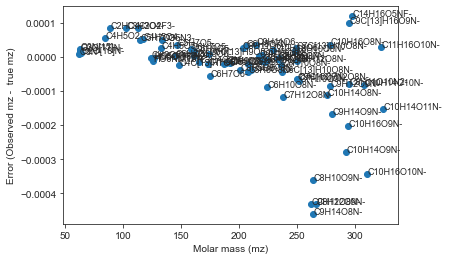

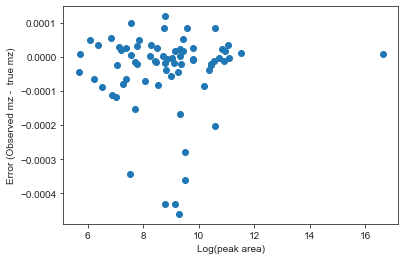

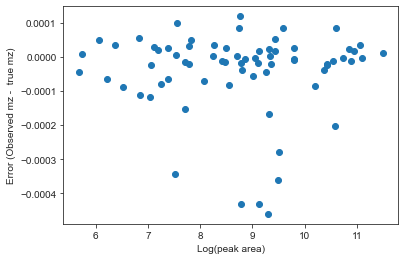

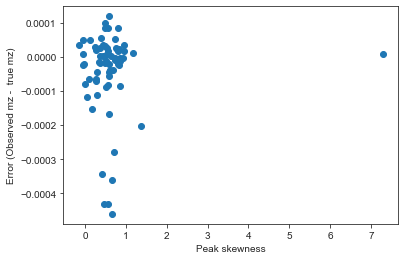

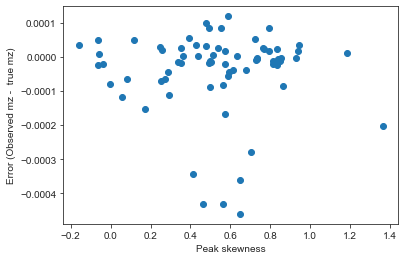


If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Negative skewness: peak top is to the right from the mean (bigger tail on the left).


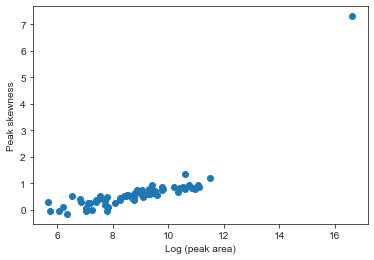

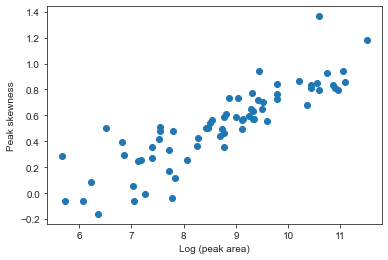

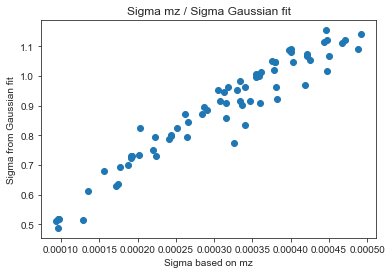

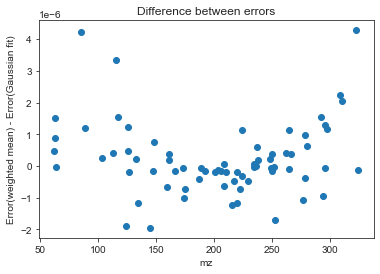

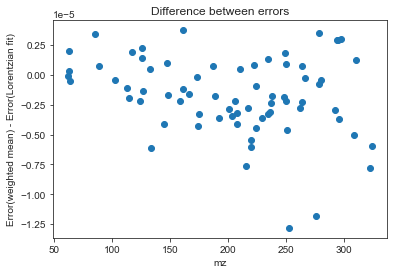

In [279]:
# Main program here

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

spectrumNumber = 4         
data = readSpectrum(spectrumNumber)    # Read the nth file in the folder of spectra

# print(data[340:353])      # Just in case, if you want to print some values from the dataframe

ionFolder = "C:/Users/kojal/pyharj/DSpro/KOionfolder/"  # Has a different structure than JKo ion file
ionFileName = ionFolder + "Allions1ex.csv"
peaklist = identifyPeaks(data, pd.read_csv(ionFileName, sep=","), 0.001)
# Rightmost value just above is the maximum alloved distance between true and observed peak

peaklist['idx'] = peaklist.index.to_numpy()    # Add index value into column 9

peaklist['centerG'] = np.zeros(len(peaklist['mz']))   #10
peaklist['sigmaG']  = np.zeros(len(peaklist['mz']))   #11
peaklist['fwhmG'] = np.zeros(len(peaklist['mz']))   #12  

peaklist['centerL'] = np.zeros(len(peaklist['mz']))   #13
peaklist['sigmaL']  = np.zeros(len(peaklist['mz']))   #14
peaklist['fwhmL'] = np.zeros(len(peaklist['mz']))   #15 

#peaklist['centerV'] = np.zeros(len(peaklist['mz']))   #16    # We skip using these
#peaklist['sigmaV']  = np.zeros(len(peaklist['mz']))   #17
#peaklist['fwhmV'] = np.zeros(len(peaklist['mz']))   #18 

addGaussians(peaklist)

#print(peaklist)

peaklist['error'] = peaklist['observed'] - peaklist['mz'] # 16
peaklist['errorG'] = peaklist['centerG'] - peaklist['mz'] # 17
peaklist['errorL'] = peaklist['centerL'] - peaklist['mz'] # 18

print(peaklist)

print("Number of actual recognized peaks: ",len(peaklist))
pd.set_option('display.max_rows', len(peaklist))
print(peaklist)   # Helps to find the number of the peak of interest
pd.reset_option('display.max_rows')




# Plot some interesting graphs

peaklist0 = peaklist.copy()
peaklist0 = peaklist0[peaklist0.loc[:,'idx'] != 1]     # Big NO3- peak
peaklist0 = peaklist0[peaklist0.loc[:,'idx'] != 29]    # Another big peak

xmz0 = peaklist0['mz']
ydiff0 = peaklist0['observed'] - peaklist0['mz'] 
names0 = peaklist0['formula']
pit0 = len(xmz0)


xmz = peaklist['mz']
ydiff = peaklist['observed'] - peaklist['mz'] 
names = peaklist['formula']
pit = len(xmz)

y = ydiff
x = xmz
fig = plt.figure()
plt.scatter(x,y)

k = names
# To see the names of compounds in the graph, uncomment these lines:
ax = fig.add_subplot(111)   # subplot not working as expected
for i,j,k in zip(x,y,k):
    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Molar mass (mz)")
plt.ylabel("Error (Observed mz -  true mz)")
#plt.figure(figsize=(3,2))           # not working right
#plt.figure(figsize=(6, 4), dpi=70)  # not working right
plt.show()


# --------------------------------------------

logarea = np.log(peaklist['area'])
x = logarea
y = ydiff
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log(peak area)")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()


logarea0 = np.log(peaklist0['area'])
x = logarea0
y = ydiff0
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log(peak area)")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()

# --------------------------------------------

x = peaklist['skew']
y = ydiff
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak skewness")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()


x = peaklist0['skew']
y = ydiff0
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak skewness")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()

# --------------------------------------------

print()
print("If skewness is less than -1 or greater than 1, the distribution is highly skewed.")
print("If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.")
print("If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.")
print()
print("Negative skewness: peak top is to the right from the mean (bigger tail on the left).")

x = logarea
y = peaklist['skew']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log (peak area)")
plt.ylabel("Peak skewness")
plt.show()


x = logarea0
y = peaklist0['skew']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log (peak area)")
plt.ylabel("Peak skewness")
plt.show()

# --------------------------------------------

x = peaklist['sigma']
y = peaklist['sigmaG']/peaklist['sigma']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Sigma based on mz")
plt.ylabel("Sigma from Gaussian fit")
plt.title("Sigma mz / Sigma Gaussian fit")
plt.show()



x = peaklist['mz']
y = peaklist['error']-peaklist['errorG']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("mz")
plt.ylabel("Error(weighted mean) - Error(Gaussian fit)")
plt.title("Difference between errors")
plt.show()


x = peaklist['mz']
y = peaklist['error']-peaklist['errorL']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("mz")
plt.ylabel("Error(weighted mean) - Error(Lorentzian fit)")
plt.title("Difference between errors")
plt.show()
# KOj 19.3. and 31.3-6.4.

## plotPeak

Choose a peak index from the printed dataframe (above) and
plot the peak for the formula in question.

NOTE:  Peak index that is not in the dataframe gives an error. (to be fixed)

         formula          mz    observed  peak          area      skew  \
1           O3N-   61.988366   61.988374     5  1.670839e+07  7.300313   
2       O3N[15]-   62.985401   62.985423     9  5.154925e+04  0.834345   
3      O2O[17]N-   62.992584   62.992602    10  1.249965e+04  0.940460   
4      O2O[18]N-   63.992613   63.992624    11  9.882738e+04  1.183740   
8        C4H5O2-   85.029503   85.029559    14  9.196109e+02  0.393910   
..           ...         ...         ...   ...           ...       ...   
262  C14H16O5NF-  297.101799  297.101919    92  6.426659e+03  0.586551   
269  C10H14O10N-  308.062319  308.062236    93  5.134488e+03  0.563726   
274  C10H16O10N-  310.077969  310.077625    94  1.852199e+03  0.414541   
279  C11H16O10N-  322.077969  322.077999    95  1.234680e+03  0.247607   
282  C10H14O11N-  324.057234  324.057080    96  2.237364e+03  0.173056   

        sigma  lefti  righti  idx     centerG    sigmaG     fwhmG     centerL  \
1    0.000094     82     325  

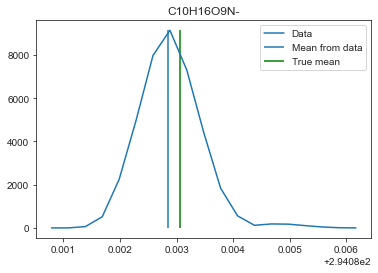

In [280]:
plotPeak(252,peaklist)  # 2, 8, 215, 269

## plotGaussian

Choose a peak index from the printed dataframe (above) and

plot the peak data and Gaussian fit data for the formula in question.

NOTE:  Peak index that is not in the dataframe gives an error. (to be fixed)

Peak of interest:  C10H16O9N-
                x            y
index                         
0      294.080789     0.000000
1      294.081088     1.357547
2      294.081387    60.301001
3      294.081686   518.371548
4      294.081985  2249.492596
5      294.082284  4977.094263
6      294.082583  7977.354935
7      294.082882  9142.763112
8      294.083181  7299.145222
9      294.083480  4415.938266
10     294.083779  1835.250619
11     294.084078   558.807268
12     294.084377   120.918981
13     294.084676   183.790566
14     294.084975   174.238269
15     294.085274   105.830609
16     294.085573    43.964039
17     294.085872     8.897287
18     294.086171     0.000000


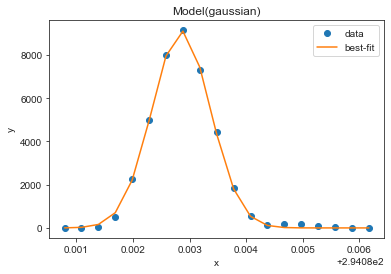

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 19
    # variables        = 3
    chi-square         = 145388.098
    reduced chi-square = 9086.75611
    Akaike info crit   = 175.911737
    Bayesian info crit = 178.745054
[[Variables]]
    amplitude:  11.7682429 +/- 0.08626905 (0.73%) (init = 12.30082)
    center:     294.082852 +/- 4.3634e-06 (0.00%) (init = 294.0827)
    sigma:      5.1498e-04 +/- 4.3625e-06 (0.85%) (init = 0.0004484718)
    fwhm:       0.00121268 +/- 1.0273e-05 (0.85%) == '2.3548200*sigma'
    height:     9116.57303 +/- 66.8648634 (0.73%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) =  0.577


In [282]:
plotGaussian(252, peaklist)


## readMultipleSpectra¶

A method to collect data from multiple spectra

First, it is necessary to establish a new dataframe for that

In [187]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

ionFolder = "C:/Users/kojal/pyharj/DSpro/KOionfolder/"  # Has a different structure than JKo ion file
ionFileName = ionFolder + "Allions1ex.csv"
dfBase = pd.read_csv(ionFileName, sep=",")
dfSize = len(dfBase)
dfBase['idx'] = dfBase.index.to_numpy() 
dfBase['count'] = np.zeros(len(dfBase), dtype="uint32")
zeroBase = np.zeros(len(dfBase), dtype="uint32")
dfBase['sum'] = np.zeros(len(dfBase))
dfBase['new'] = np.zeros(len(dfBase))

#print(dfBase)

errors = dfBase.copy()
errorsG = dfBase.copy()
errorsL = dfBase.copy()
areas = dfBase.copy()

step = 11
count = 239      #239
colBase = "t-"
for i in range(count):
    n = i*step
    colName = colBase+str(i)
    
    data = readSpectrum(n)
    peaklist = identifyPeaks(data, pd.read_csv(ionFileName, sep=","), 0.001)
    peaklist['idx'] = peaklist.index.to_numpy()    # Add index value into column 9

    peaklist['centerG'] = np.zeros(len(peaklist['mz']))   #10
    peaklist['sigmaG']  = np.zeros(len(peaklist['mz']))   #11
    peaklist['fwhmG'] = np.zeros(len(peaklist['mz']))   #12  

    peaklist['centerL'] = np.zeros(len(peaklist['mz']))   #13
    peaklist['sigmaL']  = np.zeros(len(peaklist['mz']))   #14
    peaklist['fwhmL'] = np.zeros(len(peaklist['mz']))   #15  
    
    addGaussians(peaklist)

    peaklist['error'] = peaklist['observed'] - peaklist['mz'] # 16
    peaklist['errorG'] = peaklist['centerG'] - peaklist['mz'] # 17
    peaklist['errorL'] = peaklist['centerL'] - peaklist['mz'] # 18

    for j in range(len(peaklist)):
#        zeroBase[peaklist.iloc[j,9]]=1
        errors.loc[peaklist.iloc[j,9],'count'] += 1
        errors.loc[peaklist.iloc[j,9],'new'] = peaklist.iloc[j,16]
        errorsG.loc[peaklist.iloc[j,9],'count'] += 1
        errorsG.loc[peaklist.iloc[j,9],'new'] = peaklist.iloc[j,17]  
        errorsL.loc[peaklist.iloc[j,9],'count'] += 1
        errorsL.loc[peaklist.iloc[j,9],'new'] = peaklist.iloc[j,18]
        areas.loc[peaklist.iloc[j,9],'count'] += 1
        areas.loc[peaklist.iloc[j,9],'new'] = peaklist.iloc[j,4]
    errors[colName] = errors['new']
    errors['sum'] += errors['new']
    errorsG[colName] = errorsG['new']
    errorsG['sum'] += errorsG['new']
    errorsL[colName] = errorsL['new']
    errorsL['sum'] += errorsL['new']
    areas[colName] = areas['new']
    areas['sum'] += areas['new']  
print("DONE!")

0  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-56-06.csv
Shape:      1593, 2

11  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T16-58-06.csv
Shape:      1596, 2

22  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-00-07.csv
Shape:      1628, 2

33  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-02-08.csv
Shape:      1598, 2

44  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-04-09.csv
Shape:      1655, 2

55  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-06-09.csv
Shape:      1658, 2

66  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-08-10.csv
Shape:      1610, 2

77  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T17-10-11.csv
Shape:

715  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-07-11.csv
Shape:      1533, 2

726  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-09-12.csv
Shape:      1589, 2

737  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-11-12.csv
Shape:      1638, 2

748  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-13-13.csv
Shape:      1535, 2

759  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-15-14.csv
Shape:      1648, 2

770  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-17-14.csv
Shape:      1537, 2

781  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-19-15.csv
Shape:      1581, 2

792  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T19-21-16.c

1419  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-16-15.csv
Shape:      1630, 2

1430  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-18-15.csv
Shape:      1577, 2

1441  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-20-16.csv
Shape:      1583, 2

1452  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-22-17.csv
Shape:      1633, 2

1463  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-24-20.csv
Shape:      1594, 2

1474  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-26-20.csv
Shape:      1681, 2

1485  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21-28-21.csv
Shape:      1674, 2

1496  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T21

2123  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-25-17.csv
Shape:      1667, 2

2134  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-27-17.csv
Shape:      1589, 2

2145  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-29-18.csv
Shape:      1524, 2

2156  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-31-19.csv
Shape:      1606, 2

2167  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-33-19.csv
Shape:      1533, 2

2178  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-35-20.csv
Shape:      1759, 2

2189  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23-37-21.csv
Shape:      1579, 2

2200  File name:  C:/datascienceproject/raw data/small mass deviation/deno201117n10\2020-11-17T23

In [225]:
errors2 = errors.copy()
errors2['ave'] = errors2['sum']/errors2['count']
errorsG2 = errorsG.copy()
errorsG2['ave'] = errorsG2['sum']/errorsG2['count']
errorsL2 = errorsL.copy()
errorsL2['ave'] = errorsL2['sum']/errorsL2['count']
areas2 = areas.copy()
areas2['ave'] = areas2['sum']/areas2['count']


print("------ --------------- -----")
areas2 = areas2[areas2.loc[:,'idx'] != 1]     # Big NO3- peak removed
areas2 = areas2[areas2.loc[:,'idx'] != 29]    # Another big peak removed
errors2 = errors2[errors2.loc[:,'idx'] != 1]     # Big NO3- peak removed
errors2 = errors2[errors2.loc[:,'idx'] != 29]    # Another big peak removed
errorsG2 = errorsG2[errorsG2.loc[:,'idx'] != 1]     # Big NO3- peak removed
errorsG2 = errorsG2[errorsG2.loc[:,'idx'] != 29]    # Another big peak removed
errorsL2 = errorsL2[errorsL2.loc[:,'idx'] != 1]     # Big NO3- peak removed
errorsL2 = errorsL2[errorsL2.loc[:,'idx'] != 29]    # Another big peak removed

dropLimit = 191                                                    #  <===  OBS !!!!
errors2 = errors2[errors.loc[:,'count'] > dropLimit]
errorsG2 = errorsG2[errorsG2.loc[:,'count'] > dropLimit]
errorsL2 = errorsL2[errorsL2.loc[:,'count'] > dropLimit]
areas2 = areas2[areas2.loc[:,'count'] > dropLimit]


# Removing all values with NaN (that is, ion was not detected)
#errors2 = errors2.dropna()
#errorsG2 = errorsG2.dropna()
#errorsL2 = errorsL2.dropna()
#areas2 = areas2.dropna()


print(errors2[:10])
print(errorsG2[:10])
print(errorsL2[:10])
print(areas2[:10])


print("-----------")
print(errorsG2.loc[:,'ave']-errors2.loc[:,'ave'])
print(errorsL2.loc[:,'ave']-errors2.loc[:,'ave'])

------ --------------- -----
        formula          mz  idx  count       sum       new       t-0  \
2      O3N[15]-   62.985401    2    239  0.005742  0.000023  0.000023   
3     O2O[17]N-   62.992584    3    239  0.005040  0.000024  0.000022   
4     O2O[18]N-   63.992613    4    239  0.002641  0.000010  0.000009   
9        C2HO4-   88.988032    9    239  0.021223  0.000090  0.000080   
15      C3H3O4-  103.003682   15    239  0.019523  0.000080  0.000087   
20      C2O2F3-  112.985587   20    238  0.017854  0.000049  0.000077   
25      C4H5O4-  117.019332   25    239  0.012937  0.000052  0.000052   
28      CH2O6N-  123.988760   28    238 -0.002867 -0.000023 -0.000024   
31   HO6NN[15]-  125.981044   31    239 -0.001911  0.000008 -0.000002   
32  HO5O[17]N2-  125.988226   32    239 -0.000863  0.000014 -0.000002   

             t-1           t-2       t-3  ...     t-230     t-231     t-232  \
2   2.027511e-05  2.467036e-05  0.000023  ...  0.000027  0.000025  0.000022   
3   1.839

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


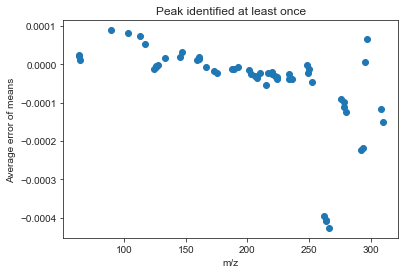

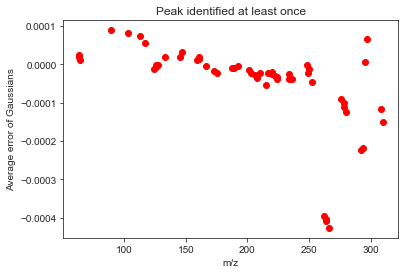

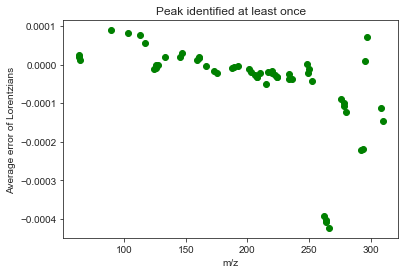

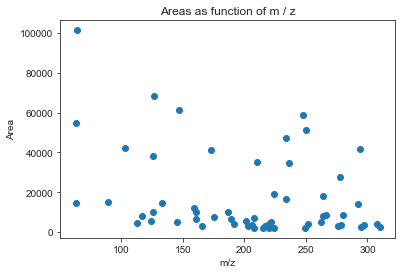

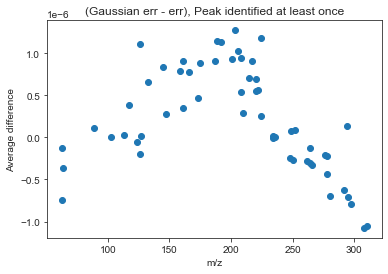

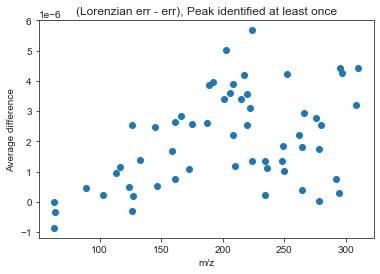

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


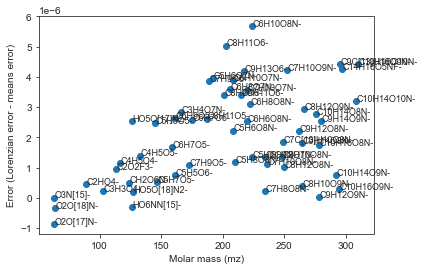

            formula          mz  idx  count
2          O3N[15]-   62.985401    2    239
3         O2O[17]N-   62.992584    3    239
4         O2O[18]N-   63.992613    4    239
9            C2HO4-   88.988032    9    239
15          C3H3O4-  103.003682   15    239
20          C2O2F3-  112.985587   20    238
25          C4H5O4-  117.019332   25    239
28          CH2O6N-  123.988760   28    238
31       HO6NN[15]-  125.981044   31    239
32      HO5O[17]N2-  125.988226   32    239
33      HO5O[18]N2-  126.988256   33    239
41          C4H5O5-  133.014247   41    239
48          C5H5O5-  145.014247   48    239
51          C5H7O5-  147.029897   51    239
59          C6H7O5-  159.029897   59    239
62          C5H5O6-  161.009161   62    239
63          C6H9O5-  161.045547   63    239
69         C3H4O7N-  165.999325   69    232
74          C7H9O5-  173.045547   74    239
76          C6H7O6-  175.024812   76    239
90         C8H11O5-  187.061197   90    239
93          C7H9O6-  189.040462 

In [228]:
x = errors2['mz']
y = errors2['ave']
fig = plt.figure()
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average error of means")
plt.title("Peak identified at least once")
plt.show()


x = errorsG2['mz']
y = errorsG2['ave']
fig = plt.figure()
plt.scatter(x,y, color = "red")

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average error of Gaussians")
plt.title("Peak identified at least once")
plt.show()


x = errorsL2['mz']
y = errorsL2['ave']
fig = plt.figure()
plt.scatter(x,y,color = "green")

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average error of Lorentzians")
plt.title("Peak identified at least once")
plt.show()

x = areas2['mz']
y = areas2['ave']
fig = plt.figure()
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Area")
plt.title("Areas as function of m / z")
plt.show()




x = errorsG2['mz']
y = errorsG2.loc[:,'ave']-errors2.loc[:,'ave']
fig = plt.figure()
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average difference")
plt.title("(Gaussian err - err), Peak identified at least once")
plt.show()


x = errorsL2['mz']
y = errorsL2.loc[:,'ave']-errors2.loc[:,'ave']
fig = plt.figure()
plt.scatter(x,y)

#To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("m/z")
plt.ylabel("Average difference")
plt.title("(Lorenzian err - err), Peak identified at least once")
plt.show()


#  Here use pyplot to annotate

xmz = errorsL2['mz']
ydiff = errorsL2.loc[:,'ave']-errors2.loc[:,'ave'] 
names = errorsL2['formula']
pit = len(xmz)

y = ydiff
x = xmz
fig = plt.figure()
plt.scatter(x,y)

k = names
# To see the names of compounds in the graph, uncomment these lines:
ax = fig.add_subplot(111)   # subplot not working as expected
for i,j,k in zip(x,y,k):
    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Molar mass (mz)")
plt.ylabel("Error (Lorenzian error - means error)")
#plt.figure(figsize=(3,2))           # not working right
#plt.figure(figsize=(6, 4), dpi=70)  # not working right
plt.show()

print(errors2.iloc[:,0:4])

## Plot ion error as function of time

Put the ion number into variable nm  e.g. 2 (+) or  25 (-)

Note: there may be no recordings on that ion number.

Ion 1 (NO3-) givess some single high error values!

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


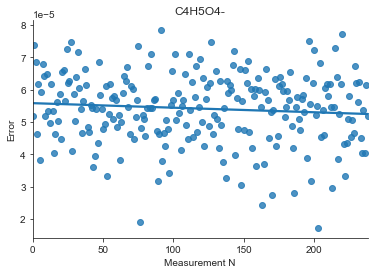

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


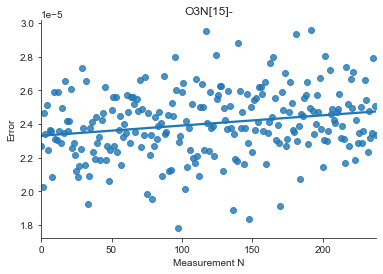

In [227]:
import seaborn as sns

nm = 25
data = errors[errors['idx']==nm].to_numpy().copy()
data = data[0]
sCount = 239   # How many spectra 239
x = np.arange(sCount)
y = data[6:len(data)]

sns.set_style('ticks')
sns.regplot(x, y, ci=None)
sns.despine()
plt.xlabel('Measurement N')
plt.ylabel('Error')
plt.title(data[0])

plt.show()   # with this, you get 2 separate graphs

nm = 2
data = errors[errors['idx']==nm].to_numpy().copy()
data = data[0]
sCount = 239   # How many spectra
x = np.arange(sCount)
y = data[6:len(data)]

sns.set_style('ticks')
sns.regplot(x, y, ci=None)
sns.despine()
plt.xlabel('Measurement N')
plt.ylabel('Error')
plt.title(data[0])

plt.show()


## Only high counts included

C:\Users\kojal\anaconda3\envs\orbitool\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


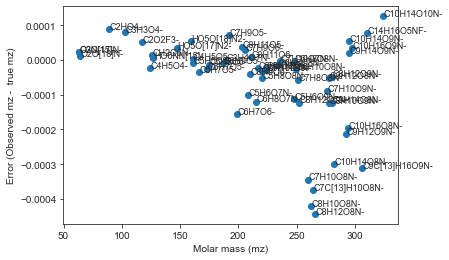

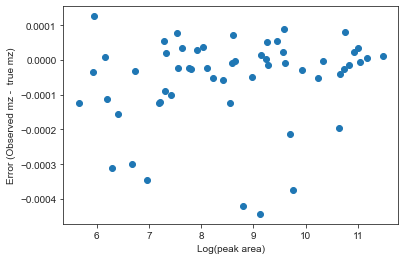

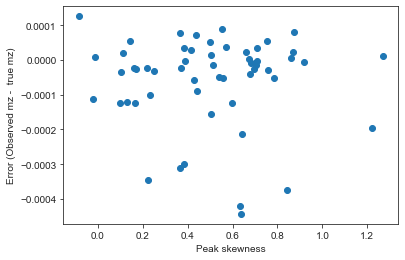


If skewness is less than -1 or greater than 1, the distribution is highly skewed.
If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.
If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

Negative skewness: peak top is to the right from the mean (bigger tail on the left).


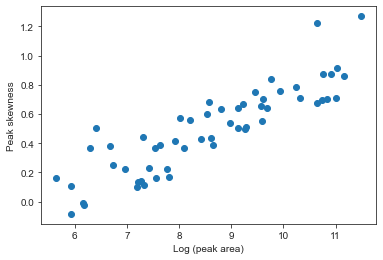

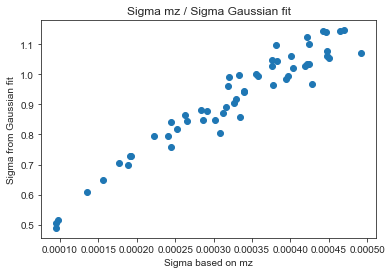

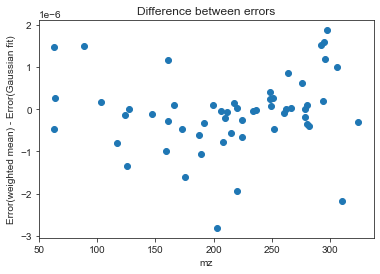

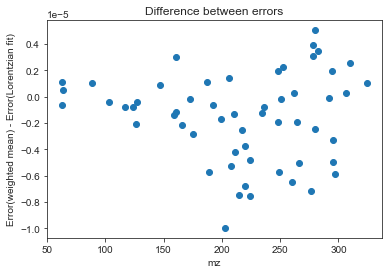

In [267]:
# Plot some interesting graphs

peaklist1 = peaklist.copy()
#print(len(peaklist1))
peaklist1 = peaklist1[peaklist1.loc[:,'idx'] != 1]     # Big NO3- peak
peaklist1 = peaklist1[peaklist1.loc[:,'idx'] != 29]    # Big HO6N2- peak

for i in range(len(errors)):
    if errors.iloc[i,3] > 165:
        peaklist1 = peaklist1[peaklist1.iloc[:,3] != errors.iloc[i,2]]

#print(len(peaklist1))


xmz1 = peaklist1['mz']
ydiff1 = peaklist1['observed'] - peaklist0['mz'] 
names1 = peaklist1['formula']
pit1 = len(xmz0)


xmz1 = peaklist1['mz']
ydiff1 = peaklist1['observed'] - peaklist1['mz'] 
names1 = peaklist1['formula']
pit1 = len(xmz1)

y = ydiff1
x = xmz1
fig = plt.figure()
plt.scatter(x,y)

k = names
# To see the names of compounds in the graph, uncomment these lines:
ax = fig.add_subplot(111)   # subplot not working as expected
for i,j,k in zip(x,y,k):
    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Molar mass (mz)")
plt.ylabel("Error (Observed mz -  true mz)")
#plt.figure(figsize=(3,2))           # not working right
#plt.figure(figsize=(6, 4), dpi=70)  # not working right
plt.show()


# --------------------------------------------


logarea1 = np.log(peaklist1['area'])
x = logarea1
y = ydiff1
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log(peak area)")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()

# --------------------------------------------


x = peaklist1['skew']
y = ydiff1
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Peak skewness")
plt.ylabel("Error (Observed mz -  true mz)")
plt.show()

# --------------------------------------------

print()
print("If skewness is less than -1 or greater than 1, the distribution is highly skewed.")
print("If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed.")
print("If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.")
print()
print("Negative skewness: peak top is to the right from the mean (bigger tail on the left).")


x = logarea1
y = peaklist1['skew']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Log (peak area)")
plt.ylabel("Peak skewness")
plt.show()

# --------------------------------------------

x = peaklist1['sigma']
y = peaklist1['sigmaG']/peaklist1['sigma']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("Sigma based on mz")
plt.ylabel("Sigma from Gaussian fit")
plt.title("Sigma mz / Sigma Gaussian fit")
plt.show()



x = peaklist1['mz']
y = peaklist1['error']-peaklist1['errorG']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("mz")
plt.ylabel("Error(weighted mean) - Error(Gaussian fit)")
plt.title("Difference between errors")
plt.show()


x = peaklist1['mz']
y = peaklist1['error']-peaklist1['errorL']
fig = plt.figure()
plt.scatter(x,y)

# To see the names of compounds in the graph, uncomment these 2 lines:
#for i,j,k in zip(x,y,k):
#    ax.annotate(str(k),xy=(i+0.4,j), fontsize = 9)

plt.xlabel("mz")
plt.ylabel("Error(weighted mean) - Error(Lorentzian fit)")
plt.title("Difference between errors")
plt.show()
# KOj 19.3. and 31.3-6.4.

In [272]:
errors.to_csv('errors.csv')
errors2.to_csv('errors2.csv')
errorsG.to_csv('errorsG.csv')
errorsG2.to_csv('errorsG2.csv')
errorsL.to_csv('errorsL.csv')
errorsL2.to_csv('errorsL2.csv')
areas.to_csv('areas.csv')
areas2.to_csv('areas2.csv')